In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from affine import Affine
from scipy.interpolate import RectBivariateSpline
from time import perf_counter
from scipy.signal import detrend
import os
 
# Datasets needed to run these codes:
# BedMachineAntarctica
# BedMachineGreenland
# http://websrv.cs.umt.edu/isis/index.php/File:Antarctica_5km_dev1.0.nc
# http://websrv.cs.umt.edu/isis/index.php/File:Greenland_5km_dev1.0.nc

path_to_datasets = '/data/fast0/datasets/'


# How much does gravitational compression deform the surface of the ice sheets?

In [2]:
rho = 917
rhow = 1000
K = 8.9e9
lmbda = 6.6e9
mu = 3.4e9
g = 9.81

def compressibility_calculation(name,fn,dx,dy,rhoi=917,rhow=1000,K=8.9e9,lmbda=6.6e9,mu=3.4e9, g=9.81):
    ds = nc.Dataset(fn)
    H = np.array(ds['thickness']).astype(float)
    B = np.array(ds['bed']).astype(float)
    M = np.array(ds['mask'])
    E = np.array(ds['errbed'])  
    
    area_of_oceans = 361.9e6 * 1e6 
    
    ice_volume = np.sum(H[M==2]) * dx * dy
    ref_mass = rhoi*ice_volume
    ref_err  = np.sum(E[M==2]) * dx * dy
    dthm_bed = ref_err / area_of_oceans * (rhoi/rhow)
    mass = rhoi * ice_volume
    water_volume = mass / rhow

    max_slr = (water_volume / area_of_oceans)
    
    height_change_from_compression = rhoi*g*H*H/2/(lmbda+2*mu/3)
    height_change_from_compression[M!=2] = 0
    volume_loss_from_compression = np.sum(height_change_from_compression) * dx * dy
    mass = rhoi * volume_loss_from_compression
    water_volume = mass / rhow
    dthm = volume_loss_from_compression / area_of_oceans
    
    print('---- %s ----'%name)
    print('     Max height change from compression: %f'%(np.max(height_change_from_compression)))
    print('     Average height change from compression: %f'%(np.mean(height_change_from_compression)))
    print('     Mass bias from compression: %f Gt'%(mass / 1e12))
    print('     Total Mass: %f million Gt'%(ref_mass / 1e12 / 1e6) )
    print (' ')


file_list = (os.path.join(path_to_datasets, "BedMachineAntarctica_2020-07-15_v02.nc"),
             os.path.join(path_to_datasets, "BedMachineGreenland-2021-04-20.nc"))


compressibility_calculation('Antarctica',file_list[0],500,500)
compressibility_calculation('Greenland',file_list[1],150,150)

---- Antarctica ----
     Max height change from compression: 11.332763
     Average height change from compression: 0.741127
     Mass bias from compression: 30203.514647 Gt
     Total Mass: 23.247375 million Gt
 
---- Greenland ----
     Max height change from compression: 5.844034
     Average height change from compression: 0.774328
     Mass bias from compression: 2994.912654 Gt
     Total Mass: 2.696536 million Gt
 


# How much does thermal contraction deform the surface of the ice sheets?

In [3]:
def thermal_calculation(file, name,dx=5000,rhoi = 917,rhow = 1000,al=5.3e-5):   
    
    ds = nc.Dataset(file)
    H = np.array(ds['thk']).squeeze()
    if name == 'Antarctica':
        T = np.array(ds['temp']).squeeze()
    elif name == 'Greenland':
        T = np.array(ds['surftemp']).squeeze()
    vol = np.sum(H) * dx**2 / 1e9 / 1e6 # "24.9 million cubic km"
    max_thermal_depression =  al * np.max(np.abs(H * T)) /2
    avg_thermal_depression =  al * np.mean(np.abs(H * T)) /2

    dV = -al * np.sum(H * T) * dx**2 /2
    dV_liquid = dV * rhoi / rhow


    print('---- %s ----'%name)
    print('     Max depression from thermal expansion: %f m'%(max_thermal_depression))
    print('     Avg depression from thermal expansion: %f m'%(avg_thermal_depression))
    #     SLR_te = 100*dV_liquid/area_of_oceans
#         area_of_oceans = 361.9e6 * 1e6  
#     print('     Sea level rise from thermal expansion: %f cm'%(SLR_te))
    print( ' ')

file_list = (os.path.join(path_to_datasets, "Antarctica_5km_dev1.0.nc"),
             os.path.join(path_to_datasets, "Greenland_5km_dev1.2.nc"))

thermal_calculation(file_list[0], 'Antarctica')
thermal_calculation(file_list[1], 'Greenland')

---- Antarctica ----
     Max depression from thermal expansion: 6.187306 m
     Avg depression from thermal expansion: 0.729268 m
 
---- Greenland ----
     Max depression from thermal expansion: 2.879391 m
     Avg depression from thermal expansion: 0.482843 m
 


# What is the rate of height change due to compression in mm/yr?

## First, load datasets

In [4]:
# First, Load the Medley et al firn + SMB dataset

# file = '/Users/BradLipovsky/Downloads/gsfc_fdm_v1_1_gris.nc'
file = '/data/fast0/datasets/gsfc_fdm_v1_1_ais.nc'

ds = nc.Dataset(file)
fac = np.array(ds['FAC'])
fx = np.array(ds['x']).astype(float)
fy = np.array(ds['y'])
ft = np.array(ds['time'])
dfac = np.diff(fac,axis=0)
Z = np.abs(dfac)
smb=np.array(ds['SMB_a'])
asmb = np.mean(smb,axis=0).transpose()
asmb[asmb<-9998] = np.nan
# smb.shape

# Load the ice thickness dataset -- Bed Machine 2
file = '/data/fast0/datasets/BedMachineAntarctica_2020-07-15_v02.nc'
dst = nc.Dataset(file)
thick = np.array(dst['thickness'])
tx = np.array(dst['x'])
ty = np.array(dst['y'])
# plt.subplots(figsize=(14,10))
# c = plt.pcolormesh(tx,ty,thick,vmin=0,vmax=4000,shading='auto',cmap='rainbow')
# plt.colorbar(c)

## Interpolate the datasets onto the lower resolution grid

In [5]:
t1_start = perf_counter()
f = RectBivariateSpline(tx,np.flipud(ty),np.flipud(thick))
t1_stop = perf_counter()
print("Elapsed time: ",t1_stop-t1_start)

# Interpolate thickness onto the firn grid
thickf = f(fy,fx)

Elapsed time:  46.66127502080053


## Do the compressibility calculation

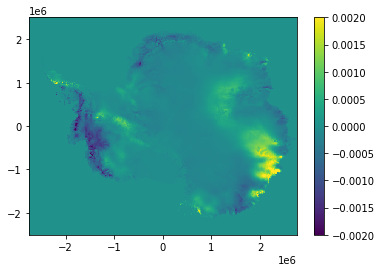

In [6]:
compression = rho*g/2/K * (np.transpose(thickf) + smb)**2
compression_rate = np.gradient(compression,ft,axis=0)

plt.subplots()
c=plt.pcolormesh(fx,fy,np.transpose(compression_rate[0,:,:]),vmin=-0.002,vmax=0.002,shading='auto')
plt.colorbar(c)

In [10]:
print('Mean rate: %f'%(np.mean(compression_rate[compression_rate!=0].flatten())))
print('Mean abs rate: %f'%(np.mean(np.abs(compression_rate[compression_rate!=0].flatten()))))
print('Median abs rate: %f'%(np.median(np.abs(compression_rate[compression_rate!=0].flatten()))))
print('Std abs rate: %f'%(np.std(np.abs(compression_rate[compression_rate!=0].flatten()))))

Mean rate: 0.000000
Mean abs rate: 0.000152
Median abs rate: 0.000060
Std abs rate: 0.000297


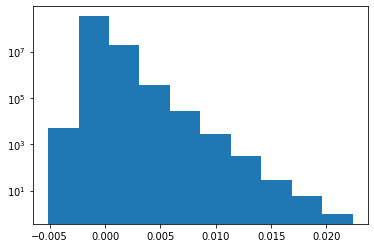

In [13]:
plt.subplots()
plt.hist(compression_rate[compression_rate!=0].flatten())
plt.yscale('log')